2025/07/13 02:14:18 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.
2025/07/13 02:14:34 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 1, Current best: 0.02779202279202286, Global best: 0.02779202279202286, Runtime: 8.03297 seconds
2025/07/13 02:14:42 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 2, Current best: 0.02779202279202286, Global best: 0.02779202279202286, Runtime: 7.92263 seconds
2025/07/13 02:14:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 3, Current best: 0.02779202279202286, Global best: 0.02779202279202286, Runtime: 7.98932 seconds
2025/07/13 02:14:58 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 4, Current best: 0.02779202279202286, Global best: 0.02779202279202286, Runtime: 8.01132 seconds
2025/07/13 02:15:06 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 5, Current best: 0.025117521367521402, Global best: 0.025117521367521


✅ Selected Features: ['WBC Count', 'Differential Count', 'Platelet Count']
Number of Features Selected: 3

✅ Best Hyperparameters Found by PSO:
n_estimators: 77
max_depth: 21
min_samples_split: 2
min_samples_leaf: 5
criterion: entropy

✅ Final CV Accuracy: 0.9763069800569799

✅ Test Accuracy: 0.9900332225913622

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        97
           1       0.99      1.00      0.99       204

    accuracy                           0.99       301
   macro avg       0.99      0.99      0.99       301
weighted avg       0.99      0.99      0.99       301


✅ Confusion Matrix:
 [[ 95   2]
 [  1 203]]


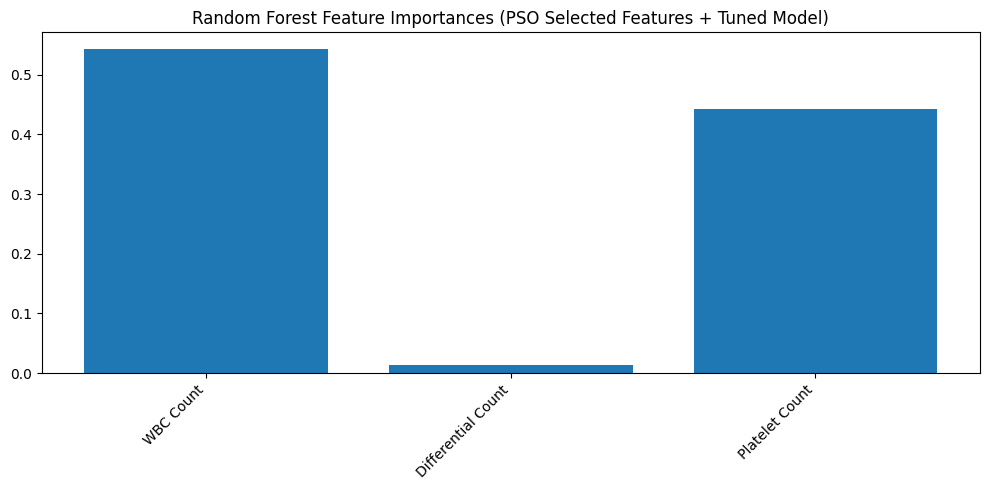

In [5]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.utils.problem import Problem
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

# Cell 2: Load and Preprocess Data
data = pd.read_csv("../Datasets/dengue.csv")
data['Sex'] = data['Sex'].map({'Male': 0, 'Female': 1, 'Child': 2})
data = data.fillna(data.mean(numeric_only=True))
X = data.drop('target', axis=1)
y = data['target'].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Cell 3: Define Fitness Function for Feature Selection + Hyperparameter Tuning
def fitness(solution):
    binary_mask = (solution[:X_train.shape[1]] > 0.5).astype(int)
    if np.sum(binary_mask) == 0:
        return 1.0

    selected_X = X_train[:, binary_mask == 1]

    n_estimators = int(solution[-5])
    max_depth = int(solution[-4]) if solution[-4] > 0 else None
    min_samples_split = int(solution[-3])
    min_samples_leaf = int(solution[-2])
    criterion = ['gini', 'entropy'][int(solution[-1])]

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, selected_X, y_train, cv=cv, scoring='accuracy')
    penalty = np.sum(binary_mask) / len(binary_mask)
    return 1 - scores.mean() + 0.01 * penalty

# Cell 4: Setup PSO for Feature Selection + Hyperparameter Optimization
feature_dim = X_train.shape[1]
lb = [0] * feature_dim + [50, 5, 2, 1, 0]
ub = [1] * feature_dim + [200, 50, 10, 5, 1]

problem = Problem(
    fit_func=fitness,
    lb=lb,
    ub=ub,
    minmax="min",
    verbose=True
)

pso = OriginalPSO(
    epoch=30,
    pop_size=10,
    c1=2.0,
    c2=2.0,
    w_min=0.4,
    w_max=0.9
)

best_position, best_fitness = pso.solve(problem)

# Cell 5: Extract and Print Results
binary_mask = (np.array(best_position[:feature_dim]) > 0.5).astype(int)
selected_indices = np.where(binary_mask == 1)[0]
selected_feature_names = X.columns[selected_indices]

n_estimators = int(best_position[-5])
max_depth = int(best_position[-4]) if best_position[-4] > 0 else None
min_samples_split = int(best_position[-3])
min_samples_leaf = int(best_position[-2])
criterion = ['gini', 'entropy'][int(best_position[-1])]

print("\n✅ Selected Features:", list(selected_feature_names))
print("Number of Features Selected:", len(selected_feature_names))
print("\n✅ Best Hyperparameters Found by PSO:")
print(f"n_estimators: {n_estimators}")
print(f"max_depth: {max_depth}")
print(f"min_samples_split: {min_samples_split}")
print(f"min_samples_leaf: {min_samples_leaf}")
print(f"criterion: {criterion}")

print("\n✅ Final CV Accuracy:", 1 - best_fitness)

# Cell 6: Train Final Model and Evaluate
X_train_selected = X_train[:, binary_mask == 1]
X_test_selected = X_test[:, binary_mask == 1]

best_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    criterion=criterion,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)

print('\n✅ Test Accuracy:', accuracy_score(y_test, y_pred))
print('\n✅ Classification Report:\n', classification_report(y_test, y_pred))
print('\n✅ Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Cell 7: Plot Feature Importance
importances = best_model.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(selected_feature_names, importances)
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest Feature Importances (PSO Selected Features + Tuned Model)")
plt.tight_layout()
plt.show()
